# Source Finders in opticam_new

`opticam_new` uses `photutils` to find sources in images. This notebook will demonstrate how to define source finders for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no source finder is specified.

## Test Image

First thing's first, let's open an image that contains some sources. For this example, I'll use one of the images from the [Basic Usage tutorial](basic_usage.ipynb):

In [1]:
from opticam_new.generate import create_synthetic_observations

create_synthetic_observations(out_dir='data', overwrite=True)  # generate some synthetic observations

Creating synthetic observations: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


In [2]:
from astropy.io import fits
import numpy as np
import os

files = os.listdir("data")
file = files[0]

with fits.open(f"data/{file}") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)
    binning_factor = int(hdul[0].header['BINNING'][0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'i       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:49'                                                 


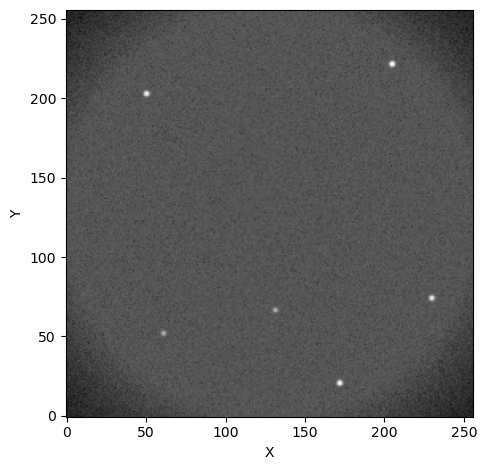

In [3]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Finder

`opticam_new` implements two default source finders: `Finder` (default) and `CrowdedFinder` (better for crowded fields, but more expensive). `Finder` does not implement any source deblending, while `CrowdedFinder` does. Both of these source finders are wrappers for `photutils.segmentation.SourceFinder` with some added convenience tailored to OPTICAM.

Let's use `opticam_new.Finder` to identify the sources in the above image:

In [4]:
from opticam_new import Finder

from photutils.segmentation import detect_threshold

default_finder = Finder()  # default values 

default_segm = default_finder(image, threshold=detect_threshold(image, nsigma=5))  # detect sources above 5 sigma
print(type(default_segm))

<class 'photutils.segmentation.core.SegmentationImage'>


When calling `opticam_new.Finder()`, a `SegmentationImage` is returned:

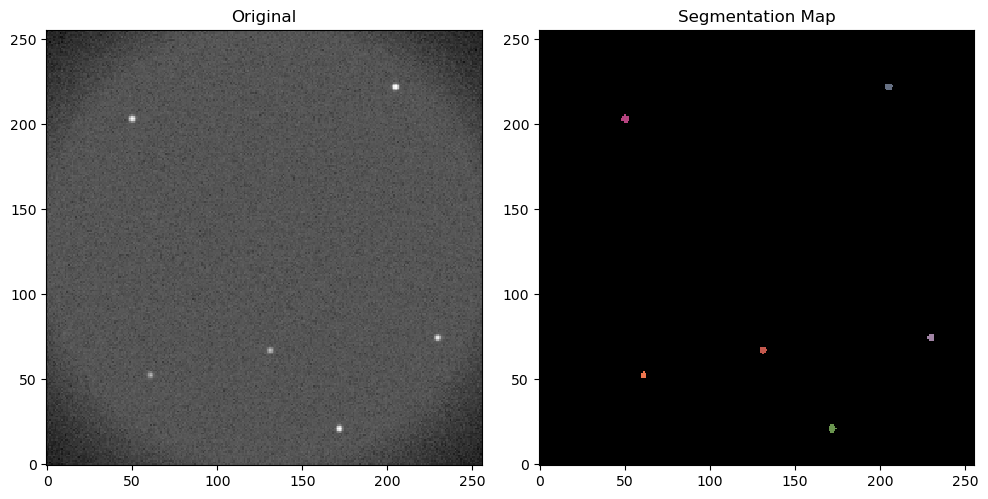

In [5]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(default_segm, origin="lower", cmap=default_segm.cmap, interpolation="nearest")

plt.show()

As we can see, all the sources have been correctly identified. We could equally have used the `CrowdedFinder` instead, though this is not necessary in this case:

In [6]:
from opticam_new import CrowdedFinder

crowded_finder = CrowdedFinder()

crowded_segm = default_finder(image, threshold=detect_threshold(image, nsigma=5))

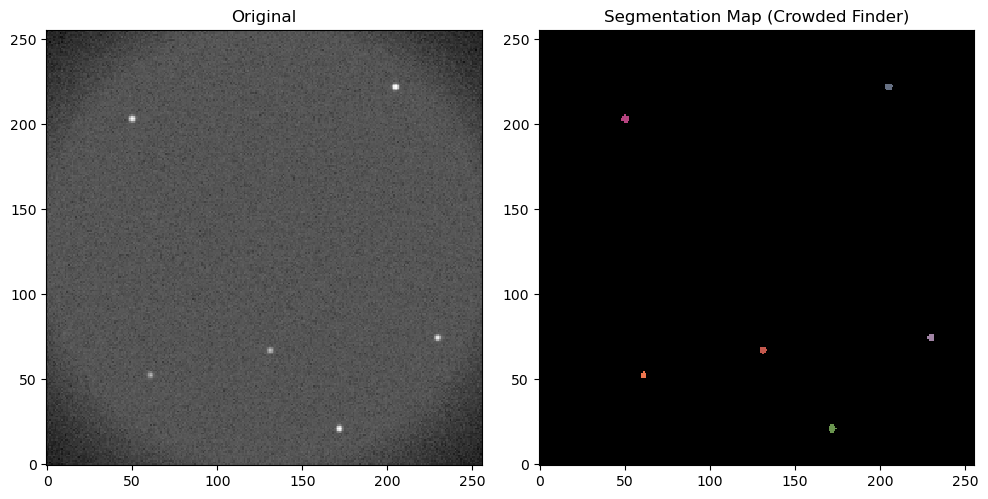

In [7]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map (Crowded Finder)")
axs[1].imshow(crowded_segm, origin="lower", cmap=crowded_segm.cmap, interpolation="nearest")

plt.show()

## Custom Source Finders

### Defining the Source Finder

Let's now define a custom source finder. Custom source finders must define a `__call__()` method that takes two parameters: `image` and `threshold`, and returns a `photutils.core.SegmentationImage`. `image` should be an `NDArray` containing the image data. `threshold` defines the threshold for source detection, typically defined in units of the background RMS:

In [8]:
from photutils.segmentation import SourceFinder

class CustomFinder(SourceFinder):
    
    def __init__(self, border_width = 0, **kwargs):
        
        self.border_width = border_width
        
        self.finder = SourceFinder(**kwargs)
    
    def __call__(self, image, threshold):
        
        segment_map = self.finder(image, threshold)
        segment_map.remove_border_labels(border_width=self.border_width, relabel=True)
        
        return segment_map

This source finder is basically a wrapper for the `SourceFinder` class from `photutils.segmentation` with an additional `border_width` parameter. It implements a custom `__call__()` method that identifies sources and removes source labels close to the edge of the image, just like `opticam_new.Finder` and `opticam_new.CrowdedFinder`. Let's initialise this custom source finder and use it to identify sources in the above image. We'll set the `npixels` and `border_width` parameters to the same values assumed by `opticam_new.Finder`, but set some custom values for the other parameters:

In [9]:
custom_finder = CustomFinder(npixels=128 // (2048 // image.shape[0])**2, border_width=image.shape[0] // 16, deblend=True,
                             nlevels=256, contrast=0, progress_bar=False)

custom_segm = custom_finder(image, threshold=detect_threshold(image, nsigma=5))

Let's plot the image to see what it looks like:

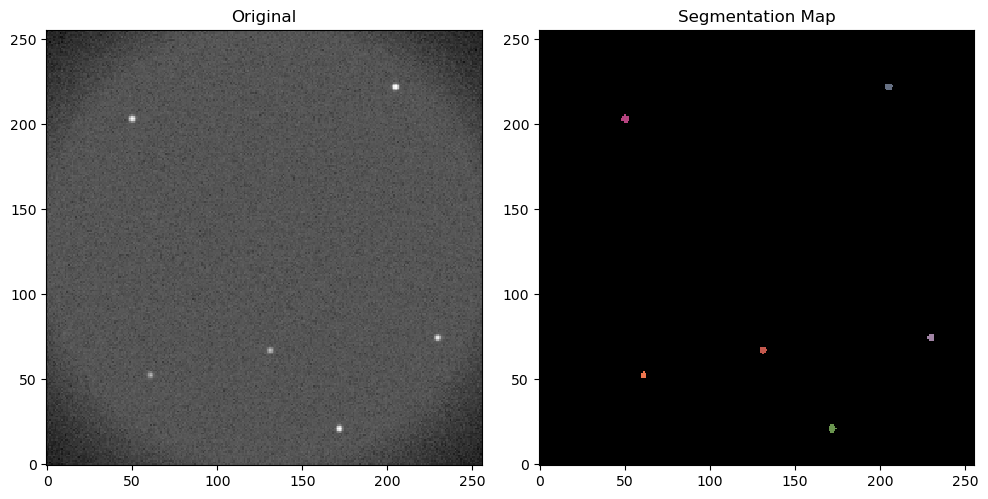

In [10]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(custom_segm, origin="lower", cmap=custom_segm.cmap, interpolation="nearest")

plt.show()

As we can see, we have once again recovered all six sources. For more information on defining custom source finders, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/segmentation.html.

That concludes the source finder tutorial for `opticam_new`! Much of the heavy lifting here is handled by `photutils`, so I'd highly recommend checking out their documentation for more information source detection using image segmentation.